In [1]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Chuẩn bị dữ liệu 

In [3]:
df = pd.read_csv('online_retail_new.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
analysis_date = np.max(df['InvoiceDate'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366994 entries, 0 to 366993
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    366994 non-null  int64         
 1   CustomerID   366994 non-null  int64         
 2   InvoiceDate  366994 non-null  datetime64[ns]
 3   Description  366994 non-null  object        
 4   Quantity     366994 non-null  int64         
 5   UnitPrice    366994 non-null  float64       
 6   SaleAmount   366994 non-null  float64       
 7   Country      366994 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 22.4+ MB


In [5]:
rfm = df.groupby('CustomerID').agg(Recency=('InvoiceDate', lambda x: (analysis_date - x.max()).days),
                                   Frequency=('InvoiceNo', lambda x: x.nunique()),
                                   Monetary=('SaleAmount', 'sum'))
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,1,6,3598.21
12348,74,3,904.44
12349,18,1,1757.55
12350,309,1,334.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,178.05


## Phân tích dữ liệu
Phần này chứa thống kê cơ bản của dữ liệu. Đây là phần quan trọng trong bất kỳ phân tích nào vì nó cho phép chúng ta hiểu rõ hơn về dữ liệu cơ bản. Phần này có hai phần chính: phân phối và sự tương quan.

In [6]:
rfm.describe()

,Recency,Frequency,Monetary
count,4219.000000,4219.000000,4219.000000
mean,83.824840,4.060678,1971.240996
std,90.086268,7.101487,8666.739032
min,0.000000,1.000000,3.750000
25%,16.000000,1.000000,302.640000
50%,46.000000,2.000000,657.800000
75%,127.000000,4.000000,1610.870000
max,339.000000,188.000000,271614.140000


- Phân bố không đồng đều:
  - `Recency` và `Monetary` có phạm vi giá trị rộng, đặc biệt là `Monetary` với độ lệch chuẩn lớn. Điều này cho thấy sự phân bố không đồng đều trong dữ liệu, với một số khách hàng có giá trị mua sắm rất cao so với phần lớn khách hàng.
  - `Frequency` có giá trị tối đa và độ lệch chuẩn thấp hơn so với Monetary, nhưng vẫn cho thấy sự phân bố không đồng đều.

- Dữ liệu bị kéo bởi *giá trị ngoại lệ*:

Giá trị tối đa rất cao so với trung bình trong cả `Monetary` và `Recency` cho thấy sự hiện diện của giá trị ngoại lệ. Điều này có thể ảnh hưởng đến kết quả phân cụm nếu không được xử lý đúng cách.

In [7]:
# Tìm giá trị ngoại lai
class OutlierDetector():
    def __init__(self, data):
        self.data = data

    def zscore(self, column, threshold=3):
        z_score = np.abs(stats.zscore(self.data[column]))
        outliers = self.data[z_score > threshold]
        return outliers

In [8]:
detector_df = OutlierDetector(df)
out_sales = detector_df.zscore('Quantity')
out_sales

,InvoiceNo,CustomerID,InvoiceDate,Description,Quantity,UnitPrice,SaleAmount,Country
978,540160,15769,2023-01-05 11:50:00,RECYCLING BAG RETROSPOT,600,1.85,1110.0,United Kingdom
1541,540245,13082,2023-01-05 15:42:00,BROCADE RING PURSE,720,0.16,115.2,United Kingdom
1865,540264,17949,2023-01-06 10:20:00,SMALL POPCORN HOLDER,600,0.72,432.0,United Kingdom
1907,540267,12415,2023-01-06 11:12:00,MINI PAINT SET VINTAGE,576,0.55,316.8,Australia
2652,540363,12971,2023-01-06 15:54:00,CHINESE DRAGON PAPER LANTERNS,600,0.25,150.0,United Kingdom
...,...,...,...,...,...,...,...,...
364694,581375,16210,2023-12-08 12:36:00,BLACK RECORD COVER FRAME,960,3.39,3254.4,United Kingdom
366188,581457,18102,2023-12-08 18:43:00,WALL ART KEEP CALM,698,4.15,2896.7,United Kingdom
366197,581458,17949,2023-12-08 18:45:00,POPCORN HOLDER,1500,0.72,1080.0,United Kingdom
366198,581459,17949,2023-12-08 18:46:00,POPCORN HOLDER,1200,0.72,864.0,United Kingdom


In [9]:
detector_rfm = OutlierDetector(rfm)
out_m = detector_rfm.zscore('Monetary')
out_m.reset_index(inplace=True)
out_m

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12415,23,21,124914.53
2,12748,0,174,28868.19
3,12931,21,13,41878.96
4,13089,2,89,52808.87
5,13098,0,28,28882.44
6,13694,3,48,62142.58
7,13798,0,55,32983.19
8,14088,9,13,50491.81
9,14096,3,17,65164.79


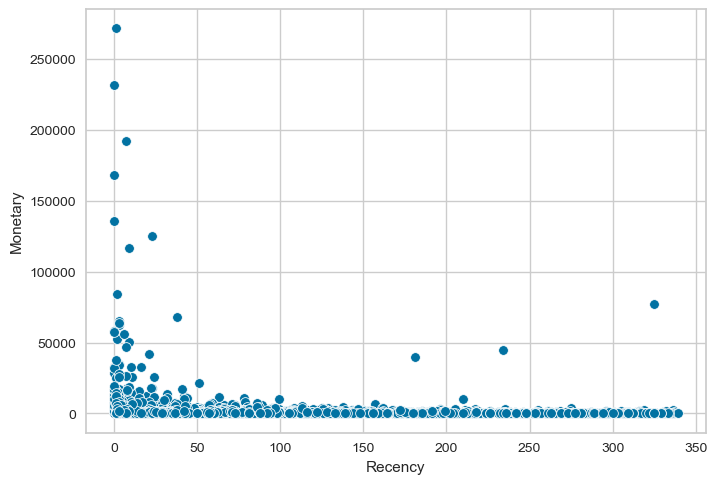

In [10]:
sns.scatterplot(x='Recency',y='Monetary', data=rfm);

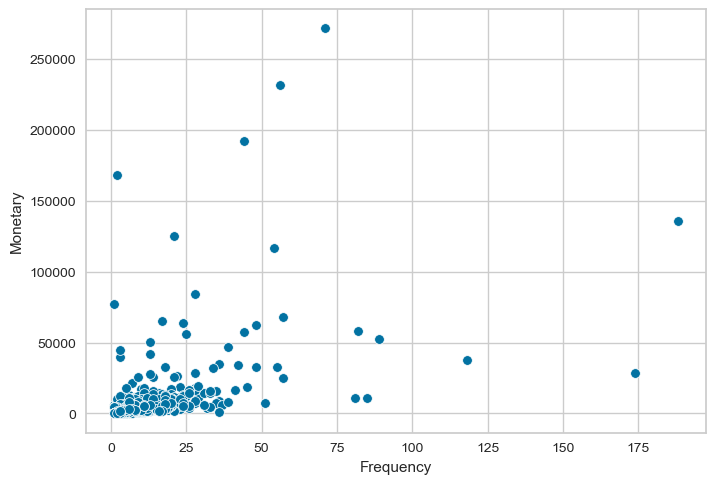

In [11]:
sns.scatterplot(x='Frequency',y='Monetary', data=rfm);

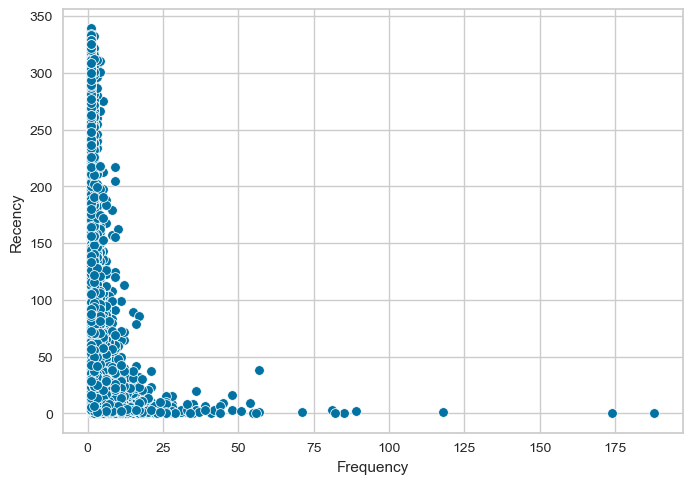

In [12]:
sns.scatterplot(x='Frequency',y='Recency', data=rfm);

In [13]:
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']]
corr_matrix = rfm_scaled.corr()

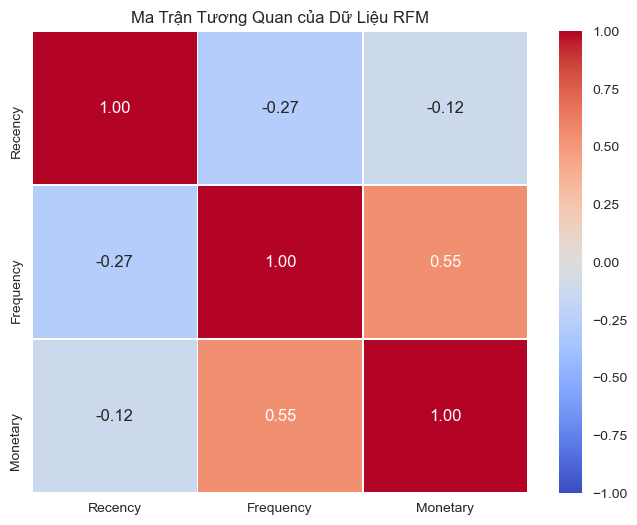

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Ma Trận Tương Quan của Dữ Liệu RFM');


- Tương quan giữa `Recency` và `Frequency` là âm (`-0.27`), cho thấy mối quan hệ ngược chiều: khi một khách hàng mua hàng thường xuyên (Frequency tăng), thời gian từ lần mua cuối cùng (Recency) thường ngắn hơn.
- Tương quan giữa `Frequency` và `Monetary` là `0.55`, cho thấy mối quan hệ dương: khách hàng mua hàng càng thường xuyên thì số tiền chi tiêu càng cao.
- Tương quan giữa `Recency` và `Monetary` là `-0.12`, cho thấy mối quan hệ ngược chiều nhưng yếu: khách hàng càng gần đây càng có xu hướng chi tiêu ít hơn một chút.

# 2. Kiểm định xem dữ liệu có cấu trúc phân cụm hay không?


Để xác định dữ liệu có thực sự có cấu trúc phân cụm hay không hay chỉ là ngẫu nhiên ta sử dụng kiểm định Hopkins.



In [15]:
# Kiểm định Hopkins
""" Sinh dữ liệu ngẫu nhiên có cùng phân phối với dữ liệu gốc """
def generate_random_data(data, n):

    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    return np.random.uniform(min_vals, max_vals, size=(n, data.shape[1]))

def hopkins_statistic(data):
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Số lượng điểm dữ liệu
    n = data.shape[0]

    # Chọn một số điểm mẫu
    sample_size = int(n*0.05)
    data_sample = data[np.random.choice(n, sample_size, replace=False)]

    # Sinh dữ liệu ngẫu nhiên
    random_data = generate_random_data(data, sample_size)

    # Tính khoảng cách
    dist_real = pairwise_distances(data_sample, data)
    dist_rand = pairwise_distances(random_data, data)

    # Tính toán chỉ số Hopkins
    H = np.sum(np.min(dist_rand, axis=1)) / (np.sum(np.min(dist_real, axis=1)) + np.sum(np.min(dist_rand, axis=1)))

    return H


In [16]:
H_data = rfm_scaled.to_numpy()
H = hopkins_statistic(H_data)
print(f'Chỉ số Hopkins :{H}')

Chỉ số Hopkins :0.999999999897837



- Dữ liệu phân phối đều: Nếu H gần 0, điều này cho thấy rằng dữ liệu có thể được phân phối đều, không có cấu trúc cụm rõ ràng. Khi X được phân phối đều, các điểm mẫu ngẫu nhiên sẽ có khoảng cách tương đối gần nhau và khoảng cách giữa các điểm trong tập dữ liệu ngẫu nhiên cũng gần nhau.

- Dữ liệu phân phối ngẫu nhiên: Nếu H gần 0.5, dữ liệu có thể là ngẫu nhiên, tức là không có xu hướng cụm rõ rệt, và sự phân bố của các điểm dữ liệu không có cấu trúc đặc biệt.

- Dữ liệu có xu hướng tập trung cao: Nếu H nằm trong khoảng 0.7 đến 0.99, điều này cho thấy dữ liệu có xu hướng tập trung và có cấu trúc cụm rõ ràng. Các điểm dữ liệu thực sự trong tập dữ liệu gần nhau hơn so với các điểm ngẫu nhiên, cho thấy sự hiện diện của các cụm.

- Cách kiểm tra giả thuyết:


Giả thuyết không (H0): Dữ liệu X được phân phối đều, tức là không có cấu trúc cụm có ý nghĩa.


Giả thuyết thay thế (H1): Dữ liệu X không được phân phối đều, tức là có cấu trúc cụm có ý nghĩa.
Khi bạn tính toán chỉ số Hopkins và nhận được giá trị cao hơn 0.75, điều đó cho thấy có sự hiện diện của cụm trong dữ liệu với mức độ tin cậy khoảng 90%.

Dựa trên giá trị của `H = 0.9999999999192263` => bác bỏ giả thuyết H0, dữ liệu có cấu trúc phân cụm

# 3. Áp dụng thuật toán phân cụm

## Kmeans 

### Chuẩn hóa dữ liệu

Chuẩn hóa dữ liệu trước khi sử dụng thuật toán phân cụm là rất quan trọng vì những lý do sau:

Đồng nhất đơn vị đo lường: Dữ liệu gốc có thể chứa các biến với các đơn vị đo lường khác nhau (ví dụ, tuổi tính bằng năm, thu nhập tính bằng đô la, chiều cao tính bằng cm). Nếu không chuẩn hóa, các biến có phạm vi giá trị lớn hơn sẽ chi phối khoảng cách giữa các điểm dữ liệu, dẫn đến các cụm không phản ánh đúng bản chất của dữ liệu.

Tăng cường hiệu quả của các thuật toán dựa trên khoảng cách: Các thuật toán phân cụm như K-means, DBSCAN, hay Agglomerative Clustering thường dựa trên việc tính toán khoảng cách (như khoảng cách Euclid) giữa các điểm dữ liệu. Nếu các đặc trưng (features) có các phạm vi giá trị khác nhau, khoảng cách này sẽ bị lệch, và kết quả phân cụm sẽ không chính xác. Chuẩn hóa giúp làm cho các đặc trưng có tầm quan trọng tương đương trong quá trình tính toán.

Tăng độ chính xác và khả năng hội tụ: Trong các thuật toán như K-means, việc chuẩn hóa giúp các cụm được hình thành nhanh hơn và chính xác hơn, do đó có thể cải thiện khả năng hội tụ và giảm thiểu số lần lặp cần thiết để đạt được kết quả cuối cùng.

Loại bỏ bias trong dữ liệu: Khi dữ liệu không được chuẩn hóa, các biến có giá trị lớn có thể làm cho mô hình học ưu tiên chúng hơn so với các biến khác, dẫn đến kết quả phân cụm bị lệch. Chuẩn hóa giúp đảm bảo rằng mỗi đặc trưng có cùng tầm quan trọng trong quá trình phân cụm.

Các phương pháp chuẩn hóa phổ biến bao gồm Min-Max Scaling (đưa các giá trị về khoảng [0, 1]) và Z-score Standardization (chuẩn hóa để có giá trị trung bình bằng 0 và độ lệch chuẩn bằng 1).

In [17]:
# Chuẩn hóa min-max
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)
rfm_scaled

array([[9.58702065e-01, 0.00000000e+00, 2.84156471e-01],
       [2.94985251e-03, 2.67379679e-02, 1.32338825e-02],
       [2.18289086e-01, 1.06951872e-02, 3.31611026e-03],
       ...,
       [2.06489676e-02, 5.34759358e-03, 6.41728028e-04],
       [8.84955752e-03, 8.02139037e-02, 7.51731184e-03],
       [1.23893805e-01, 1.06951872e-02, 6.75058859e-03]])

###  Chọn số lượng cụm tối ưu bằng thuật toán Elbow

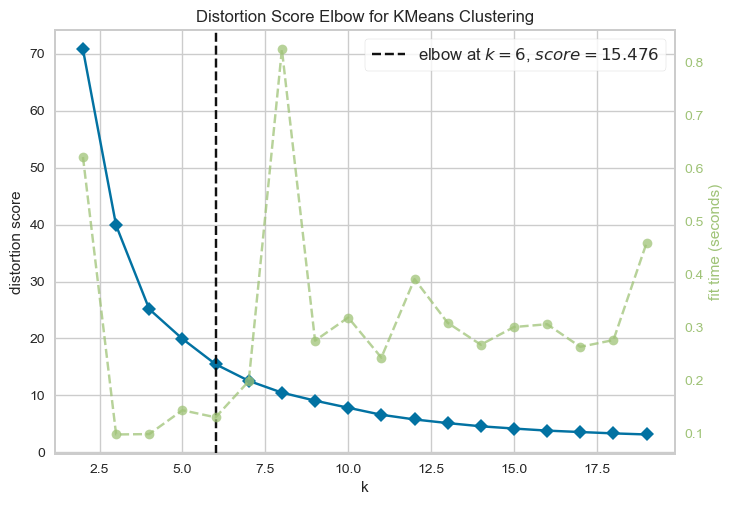

In [18]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(rfm_scaled)
elbow.show();

Biểu đồ trên cho thấy mức giảm điểm biến dạng khi số lượng cụm tăng lên. Tuy nhiên, không có "elbow" rõ ràng. Thuật toán cơ bản gợi ý 6 cụm

In [19]:
# Lấy giá trị elbow
optimal_clusters = elbow.elbow_value_
print(f'Số lượng cụm tối ưu theo thuật toán elbow: {optimal_clusters}')

Số lượng cụm tối ưu theo thuật toán elbow: 6


###  Áp dụng thuật toán phân cụm K-means 

#### Phân cụm theo phương pháp elbows k=6

In [20]:
# k = 6
model = KMeans(optimal_clusters, init='k-means++', n_init=20, random_state=42).fit(rfm_scaled)

In [21]:
# Tâm cụm sau khi được phân cụm
cluster_centers = model.cluster_centers_
cluster_centers

array([[0.38314176, 0.00663839, 0.00291568],
       [0.04769636, 0.02471819, 0.0085796 ],
       [0.85275891, 0.00093963, 0.00205313],
       [0.01587302, 0.36159919, 0.32438641],
       [0.60507753, 0.00341414, 0.00250199],
       [0.1903145 , 0.0086757 , 0.0039248 ]])

In [22]:
# Chuyển đổi ngược tâm cụm về không gian gốc
centroids_original = scaler.inverse_transform(cluster_centers)
for i, cluster_center in enumerate(centroids_original):
    print(f'Cluster {i + 1}: Recency = {cluster_center[0]:.2f}, Frequency = {cluster_center[1]:.2f}, Monetary = {cluster_center[2]:.2f}')

Cluster 1: Recency = 129.89, Frequency = 2.24, Monetary = 795.68
Cluster 2: Recency = 16.17, Frequency = 5.62, Monetary = 2334.06
Cluster 3: Recency = 289.09, Frequency = 1.18, Monetary = 561.40
Cluster 4: Recency = 5.38, Frequency = 68.62, Monetary = 88110.47
Cluster 5: Recency = 205.12, Frequency = 1.64, Monetary = 683.32
Cluster 6: Recency = 64.52, Frequency = 2.62, Monetary = 1069.77


In [23]:
print(f'Inertia của mô hình KMeans: {model.inertia_}')

Inertia của mô hình KMeans: 15.474212067315127


In [24]:
# Gán label vào các cụm tương ứng
clusters = model.labels_
rfm_kmeans = rfm[['Recency', 'Frequency', 'Monetary']]
rfm_kmeans['Cluster'] = clusters + 1
rfm_kmeans = rfm_kmeans.reset_index()
rfm_kmeans.to_csv('rfm_kmeans.csv', index=False)
rfm_kmeans.head(5)

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,325,1,77183.60,3
1,12347,1,6,3598.21,2
2,12348,74,3,904.44,6
3,12349,18,1,1757.55,2
4,12350,309,1,334.40,3


In [59]:
cluster_count =  rfm_kmeans.groupby('Cluster').size().to_frame()
cluster_count.rename(columns={0:'Số KH'})

,Số KH
Cluster,
1,435
2,1946
3,387
4,21
5,437
6,993


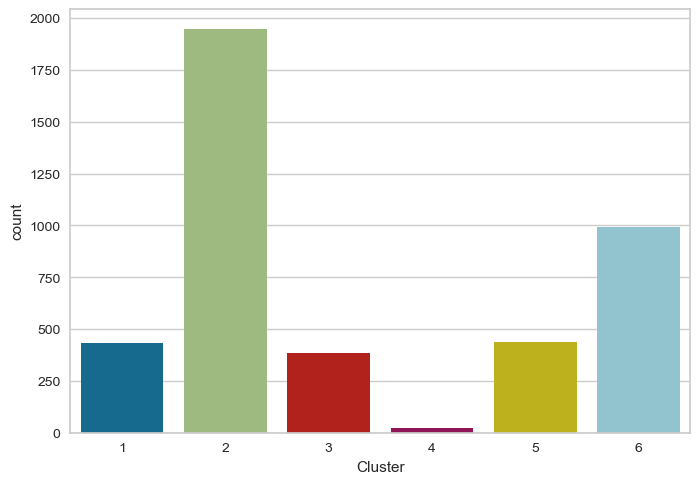

In [26]:
sns.countplot(x='Cluster', data=rfm_kmeans);

### Đánh giá kết quả phân cụm

#### Tính điểm Silhouette

In [27]:
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    # Phân cụm dữ liệu
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(rfm_scaled)
    
    # Tính Silhouette Score
    score = silhouette_score(rfm_scaled, clusters)
    silhouette_scores.append(score)
    
    # In kết quả
    print(f'Số lượng cụm: {k}, Silhouette Score: {score:.3f}')

Số lượng cụm: 2, Silhouette Score: 0.721
Số lượng cụm: 3, Silhouette Score: 0.631
Số lượng cụm: 4, Silhouette Score: 0.571
Số lượng cụm: 5, Silhouette Score: 0.546
Số lượng cụm: 6, Silhouette Score: 0.558
Số lượng cụm: 7, Silhouette Score: 0.537
Số lượng cụm: 8, Silhouette Score: 0.474
Số lượng cụm: 9, Silhouette Score: 0.496
Số lượng cụm: 10, Silhouette Score: 0.497


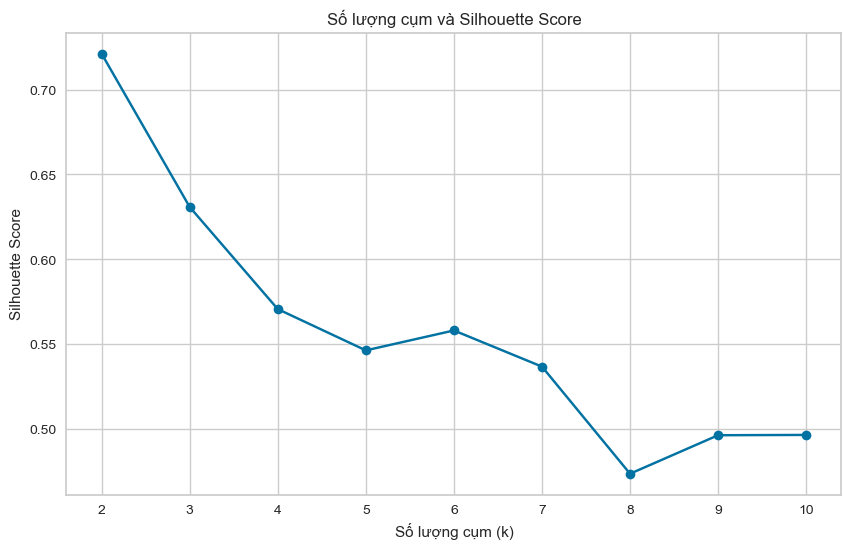

In [28]:
# Vẽ biểu đồ Silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Silhouette Score')
plt.title('Số lượng cụm và Silhouette Score')
plt.grid(True)
plt.show()

Điểm Silhouette đánh giá mức độ tương đồng của các điểm trong cụm và mức độ tương đồng với các điểm trong cụm lân cận. 

Điểm Silhouette có giá trị dao động từ [-1,1]

- Giá trị gần 1: Cho thấy các đối tượng trong cụm được phân cụm tốt và các cụm riêng biệt rõ ràng.
- Giá trị gần 0: Cho thấy các đối tượng nằm giữa các cụm, tức là các cụm có thể không rõ ràng hoặc chồng lấn.
- Giá trị gần -1: Cho thấy các đối tượng có thể đã bị phân cụm sai, và chúng nên được phân vào cụm khác.

Với k=6 điểm Silhouette là `0.558`, điều này cho thấy các cụm trong mô hình phân cụm có sự tách biệt khá tốt. Các đối tượng trong các cụm phần lớn thuộc về đúng cụm, và các cụm có sự khác biệt rõ ràng với nhau, mặc dù có thể vẫn có một số chồng lấn nhỏ giữa các cụm.

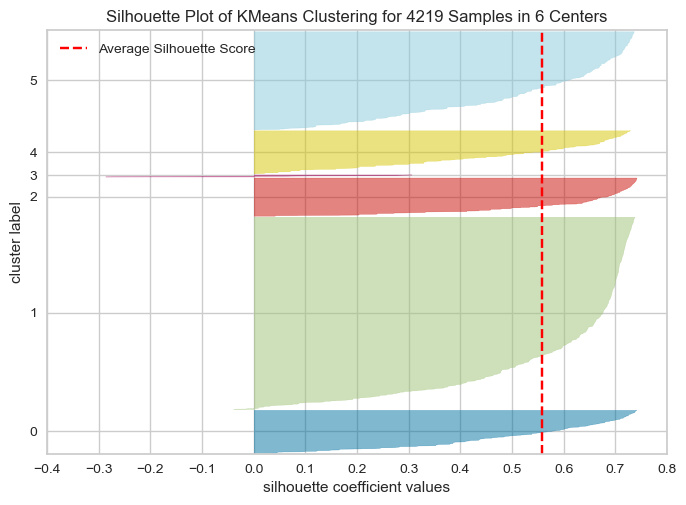

In [29]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(rfm_scaled)
visualizer.show();

- Cluster 1, 3 (xanh lá, đỏ): Có một số mẫu có giá trị Silhouette âm, cho thấy một số mẫu trong cụm này có thể bị phân cụm sai hoặc nằm gần ranh giới giữa các cụm.
- Các cụm khác (4, 5): Có giá trị Silhouette chủ yếu dương, chỉ ra rằng các mẫu này được phân cụm tốt và nằm gần trung tâm cụm của chúng.
Kết quả:
- Phân cụm hiệu quả: Đối với phần lớn các cụm, các mẫu được phân cụm tốt, chỉ có một vài cụm (như cụm 3) có vấn đề về phân cụm. Điều này có nghĩa rằng KMeans với 6 cụm là lựa chọn hợp lý cho bộ dữ liệu này.
- Điểm cần cải thiện: Cụm 3 có thể cần được xem xét lại. Có thể cần thay đổi số lượng cụm hoặc các tham số khác để cải thiện việc phân cụm cho các mẫu này.
- 
Nhìn chung, việc sử dụng 6 cụm mang lại kết quả tốt, nhưng việc tinh chỉnh thêm có thể giúp cải thiện chất lượng phân cụm cho các mẫu khó phân loại.

### Trực quan hóa kết quả phân cụm trên toạn độ 2D

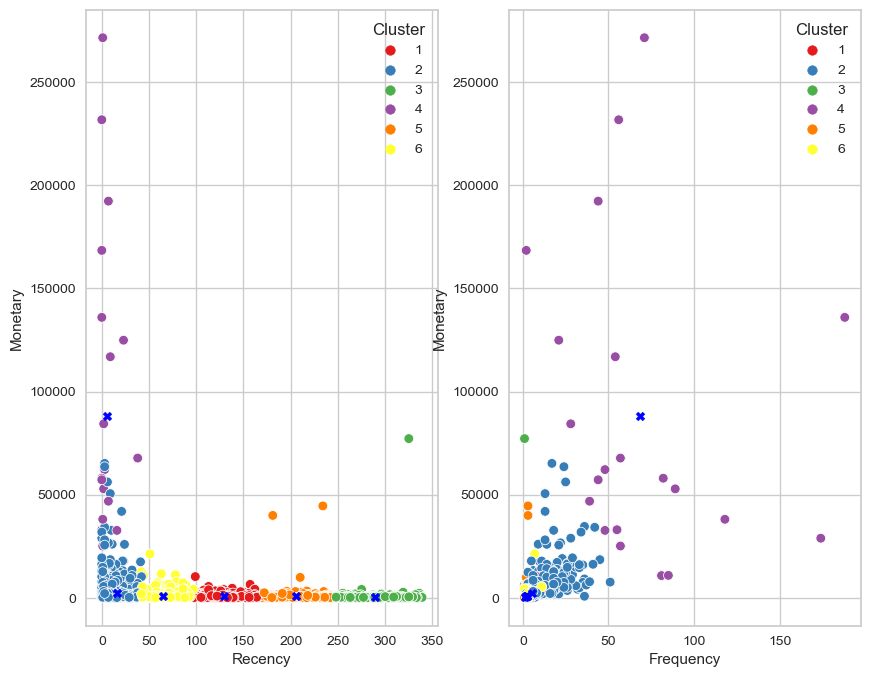

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10,8))
sns.scatterplot('Recency', 'Monetary', data=rfm_kmeans,
                hue='Cluster', ax=axs[0], palette='Set1', legend='full')
axs[0].scatter(centroids_original[:,0], centroids_original[:,2], 
               marker='X', s=40, c="blue")
sns.scatterplot('Frequency', 'Monetary', data=rfm_kmeans,
                hue='Cluster', ax=axs[1], palette='Set1', legend='full')
axs[1].scatter(centroids_original[:,1], centroids_original[:,2],
               marker='X', s=40, c='blue')
plt.show()

### Trực quan hóa kết quả phân cụm trên tọa độ 3D

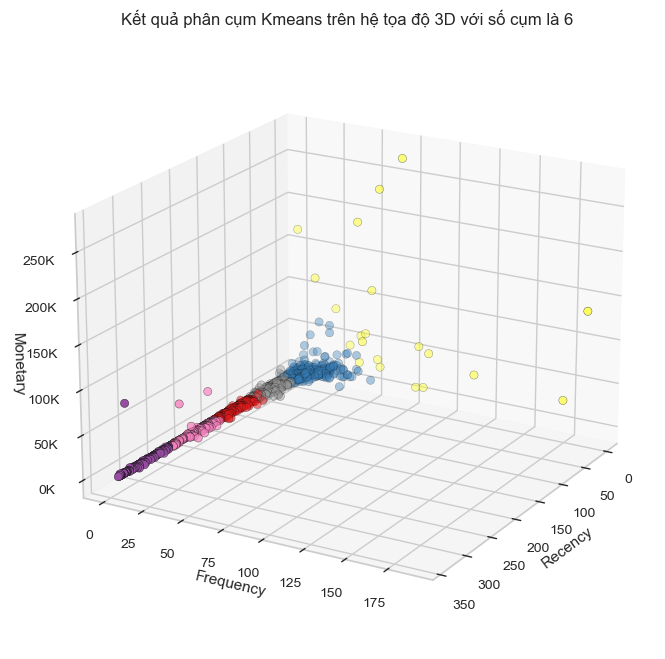

In [31]:
# Tạo scatter plot 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# for cluster in range(1, optimal_clusters+1):
#     cluster_data = rfm_kmeans[rfm_kmeans['Cluster'] == cluster]
ax.scatter(rfm_kmeans['Recency'],
           rfm_kmeans['Frequency'], 
           rfm_kmeans['Monetary'],
           c=rfm_kmeans['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)


ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.zaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0fK' % (x * 1e-3)))
ax.set_title(f'Kết quả phân cụm Kmeans trên hệ tọa độ 3D với số cụm là {optimal_clusters}')



ax.view_init(elev=20, azim=30)  # elev là góc nâng, azim là góc phương vị
plt.show()


## Kmeans sử dụng PCA

In [32]:
pca = PCA(n_components=2)

In [33]:
pca_result = pca.fit_transform(rfm_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.96799607 0.02490386]


PC1: Thành phần chính đầu tiên (PC1) giải thích 96.8% tổng phương sai của dữ liệu ban đầu.
PC2: Thành phần chính thứ hai (PC2) giải thích thêm 2.49% nữa.
Tổng của hai giá trị này là 99.3%, nghĩa là chỉ với hai thành phần chính giữ lại 99.3% thông tin gốc từ dữ liệu.

In [34]:
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca

,PC1,PC2
0,0.707328,0.184469
1,-0.244602,0.002049
2,-0.028675,-0.008049
3,-0.193349,-0.021234
4,0.664380,0.010046
...,...,...
4214,0.570077,0.005910
4215,0.284198,-0.005806
4216,-0.225892,-0.021850
4217,-0.240720,0.041130


### Sử dụng Elbow Score để chọn số cụm tối ưu

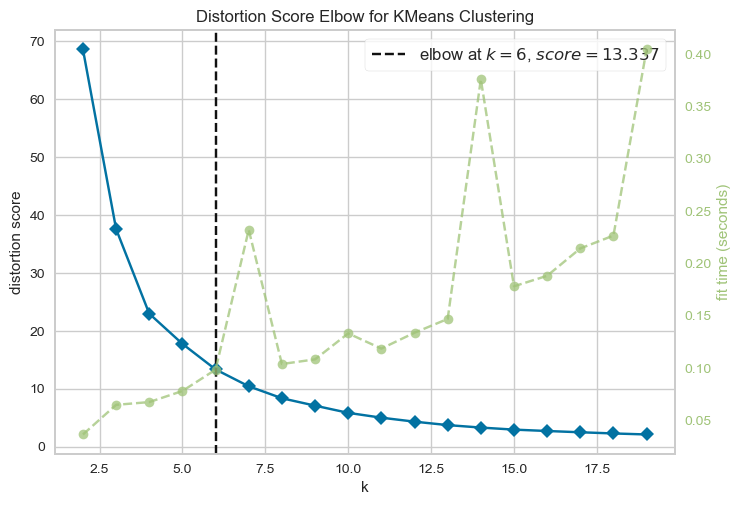

In [35]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(pca_result)
elbow.show();

In [36]:
optimal_clusters = elbow.elbow_value_
print(f'Số cụm tối ưu do phương pháp elbow lựa chọn: {optimal_clusters}')

Số cụm tối ưu do phương pháp elbow lựa chọn: 6


### Áp dụng Kmeans cho dữ liệu đã được giảm chiều 

In [37]:
model =  KMeans(optimal_clusters, init='k-means++', n_init=20, random_state=42).fit(df_pca)

In [38]:
# Các cụm sau khi áp dụng Kmeans

clusters = model.labels_
clusters

array([5, 0, 3, ..., 0, 0, 3])

In [39]:
# Gắn nhãn cụm vào DataFrame
df_pca['Cluster'] = clusters
df_pca


,PC1,PC2,Cluster
0,0.707328,0.184469,5
1,-0.244602,0.002049,0
2,-0.028675,-0.008049,3
3,-0.193349,-0.021234,0
4,0.664380,0.010046,5
...,...,...,...
4214,0.570077,0.005910,5
4215,0.284198,-0.005806,1
4216,-0.225892,-0.021850,0
4217,-0.240720,0.041130,0


In [40]:
rfm_pca = rfm[['Recency', 'Frequency', 'Monetary']]
rfm_pca['Cluster'] = clusters + 1
rfm_pca = rfm_pca.reset_index()
rfm_pca.to_csv('rfm_pca.csv')
rfm_pca

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,325,1,77183.60,6
1,12347,1,6,3598.21,1
2,12348,74,3,904.44,4
3,12349,18,1,1757.55,1
4,12350,309,1,334.40,6
...,...,...,...,...,...
4214,18280,277,1,180.60,6
4215,18281,180,1,80.82,2
4216,18282,7,2,178.05,1
4217,18283,3,16,2045.53,1


In [41]:
cluster_count =  rfm_pca.groupby('Cluster').size().to_frame()
cluster_count.rename(columns={0:'Số khách hàng'})

,Số khách hàng
Cluster,
1,1954
2,397
3,459
4,1010
5,21
6,378


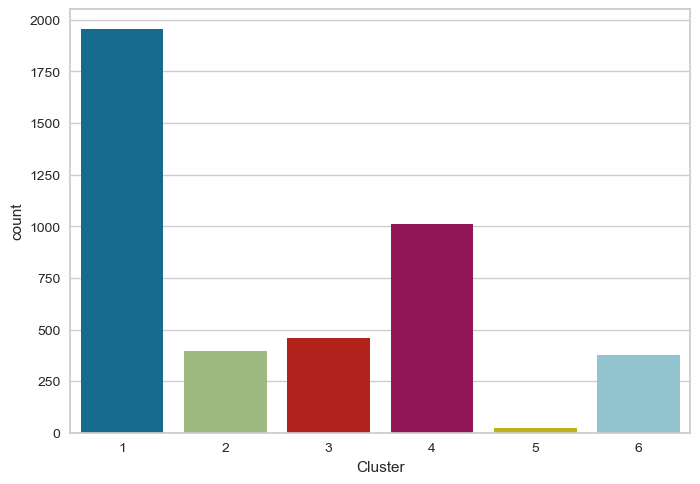

In [42]:
sns.countplot(x='Cluster', data=rfm_pca);

### Đánh giá mô hình

In [43]:
# Tính điểm Silhouette cho các số lượng cụm khác nhau
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    # Phân cụm dữ liệu
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df_pca)
    
    # Tính Silhouette Score
    score = silhouette_score(df_pca, clusters)
    silhouette_scores.append(score)
    
    # In kết quả
    print(f'Số lượng cụm: {k}, Silhouette Score: {score:.3f}')

Số lượng cụm: 2, Silhouette Score: 0.755
Số lượng cụm: 3, Silhouette Score: 0.811
Số lượng cụm: 4, Silhouette Score: 0.863
Số lượng cụm: 5, Silhouette Score: 0.937
Số lượng cụm: 6, Silhouette Score: 0.943
Số lượng cụm: 7, Silhouette Score: 0.706
Số lượng cụm: 8, Silhouette Score: 0.679
Số lượng cụm: 9, Silhouette Score: 0.591
Số lượng cụm: 10, Silhouette Score: 0.558


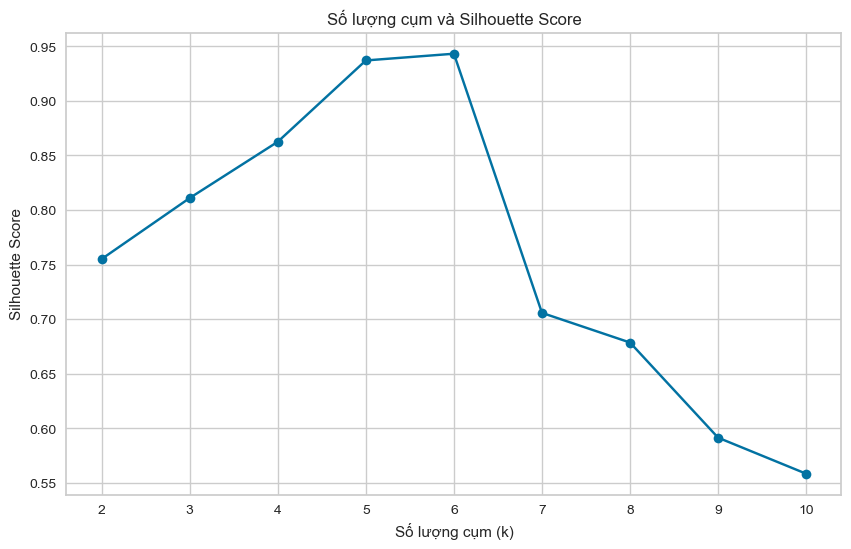

In [44]:
# Vẽ biểu đồ Silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Silhouette Score')
plt.title('Số lượng cụm và Silhouette Score')
plt.grid(True)
plt.show()

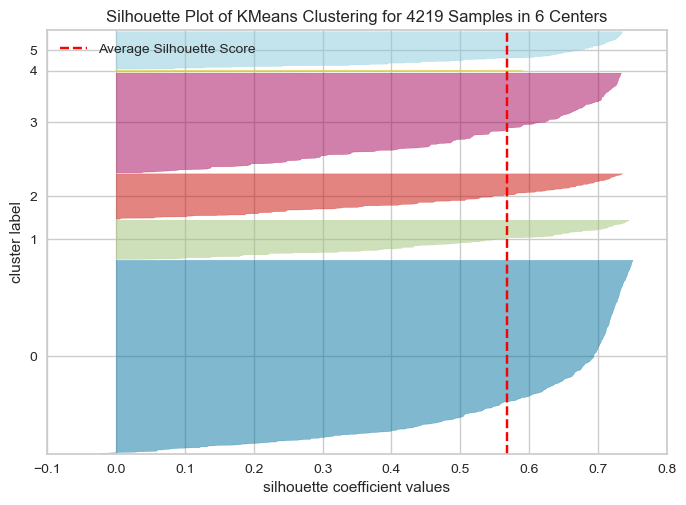

In [45]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(pca_result)
visualizer.show();

- So với phân cụm Kmeans không sử dụng PCA ta thấy chất lượng phân cụm tốt hơn với điểm silhouette trung bình cho 6 cụm là cao nhất `0.943`
- Các giá trị silhouette ít giá trị âm hơn


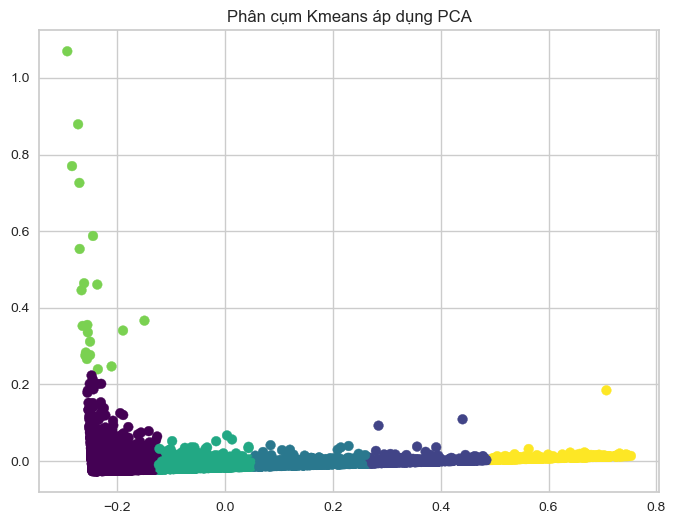

In [56]:
# Trực quan hóa phân cụm
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis')
plt.title('Phân cụm Kmeans áp dụng PCA')
plt.show()

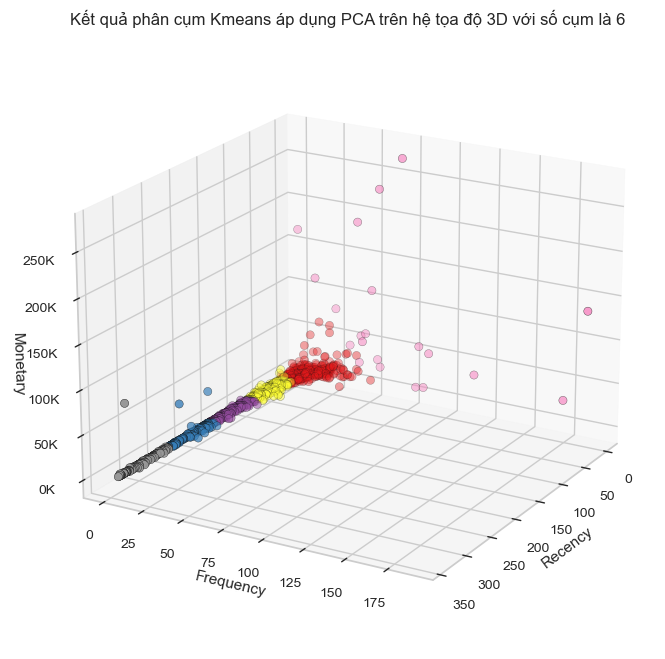

In [57]:
# Tạo scatter plot 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# for cluster in range(1, optimal_clusters+1):
#     cluster_data = rfm_kmeans[rfm_kmeans['Cluster'] == cluster]
ax.scatter(rfm_pca['Recency'],
           rfm_pca['Frequency'], 
           rfm_pca['Monetary'],
           c=rfm_pca['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)


ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.zaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0fK' % (x * 1e-3)))
ax.set_title(f'Kết quả phân cụm Kmeans áp dụng PCA trên hệ tọa độ 3D với số cụm là {optimal_clusters}')



ax.view_init(elev=20, azim=30)  # elev là góc nâng, azim là góc phương vị
plt.show()


## DBSCAN

DBSCAN là một thuật toán cơ sở để phân nhóm dựa trên mật độ. Nó có thể phát hiện ra các cụm có hình dạng và kích thước khác nhau từ một lượng lớn dữ liệu chứa nhiễu.

Trong DBSCAN có hai tham số chính:
- `min_samples`: Số điểm tối thiểu trong khoảng cách Eps
- `eps`: bán kính của vùng lân cận


In [48]:
from sklearn.neighbors import NearestNeighbors

In [49]:
min_samples = 6
# Xây dựng mô hình k-NN 
k = min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(rfm_scaled)

In [50]:
# Ma trận khoảng cách distances: (N, k)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)
# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, k-1], reverse=True)

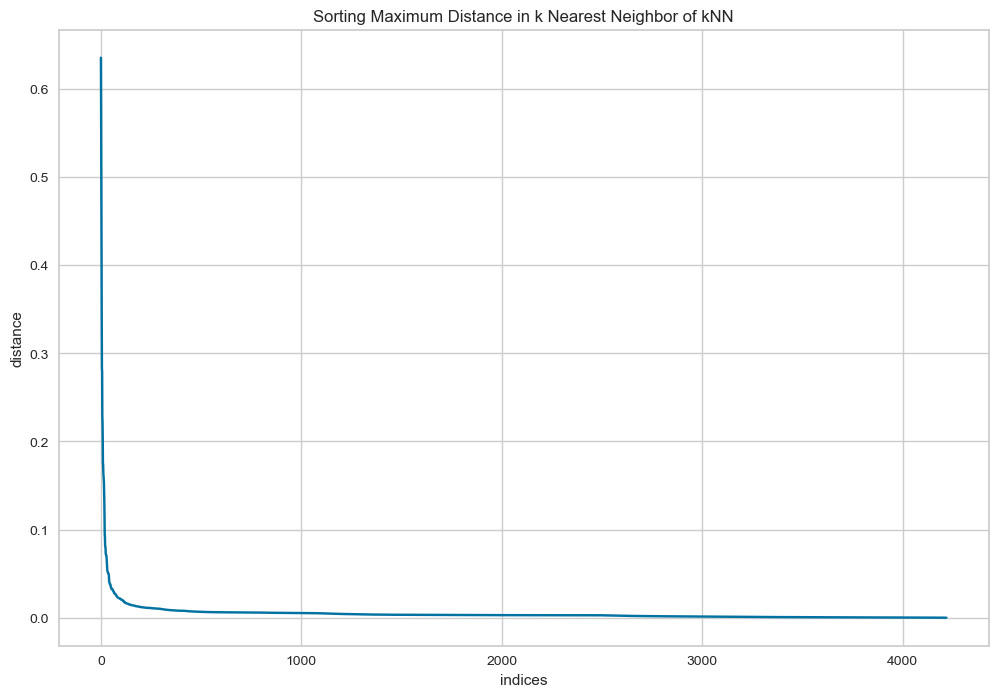

In [51]:
# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(distance_desc)
plt.ylabel('distance')
plt.xlabel('indices')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN');

- Xác định "elbow" trong biểu đồ: Điểm "elbow" là điểm mà từ đó đường cong bắt đầu phẳng ra, tức là khi độ dốc giảm đáng kể. 

- Chọn epsilon gần điểm "elbow": Giá trị epsilon nên được chọn tại hoặc ngay sau điểm "elbow". Điều này đảm bảo rằng bạn chọn được khoảng cách đủ lớn để bao gồm các điểm lân cận thực sự gần nhau nhưng không quá lớn để nhóm các điểm nhiễu.

Trong biểu đồ trên điểm "elbow" rõ ràng nằm ở khoảng từ `0.02` đến `0.1`. Khi giá trị eps quá nhỏ thì sẽ không phân cụm được nhiều nhiễu.

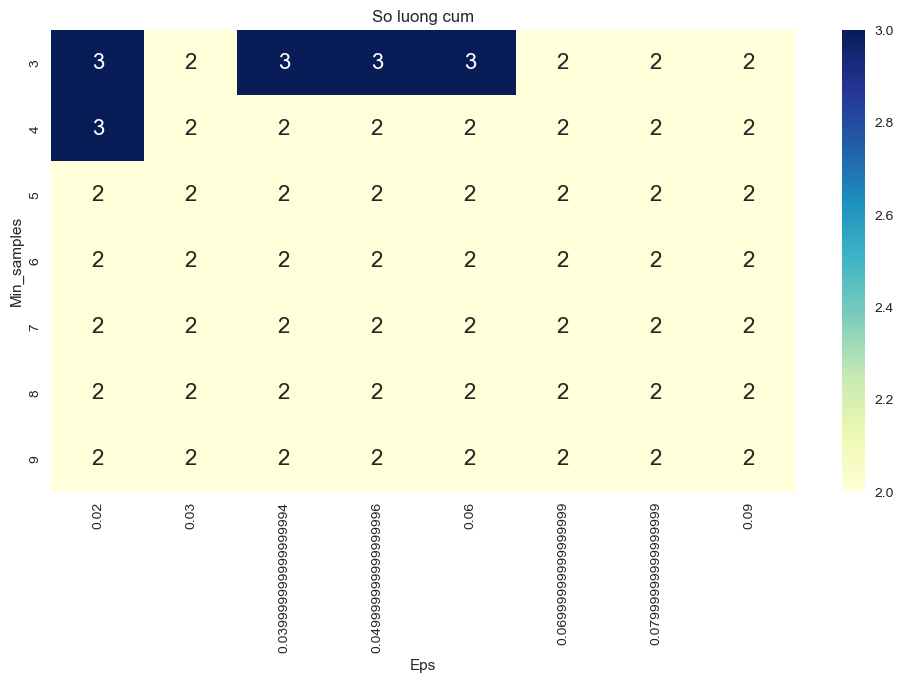

In [52]:
from itertools import product

eps_values = np.arange(0.02, 0.1, 0.01) # giá trị eps cần kiểm tra
min_samples = np.arange(3, 10) # giá trị min_samples cần kiểm tra

DBSCAN_params = list(product(eps_values, min_samples))

no_of_clusters = []
sil_score = []
X_numerics = rfm[['Recency', 'Frequency', 'Monetary']]
for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(rfm_scaled)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(rfm_scaled, DBS_clustering.labels_))

tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('So luong cum')
plt.show()

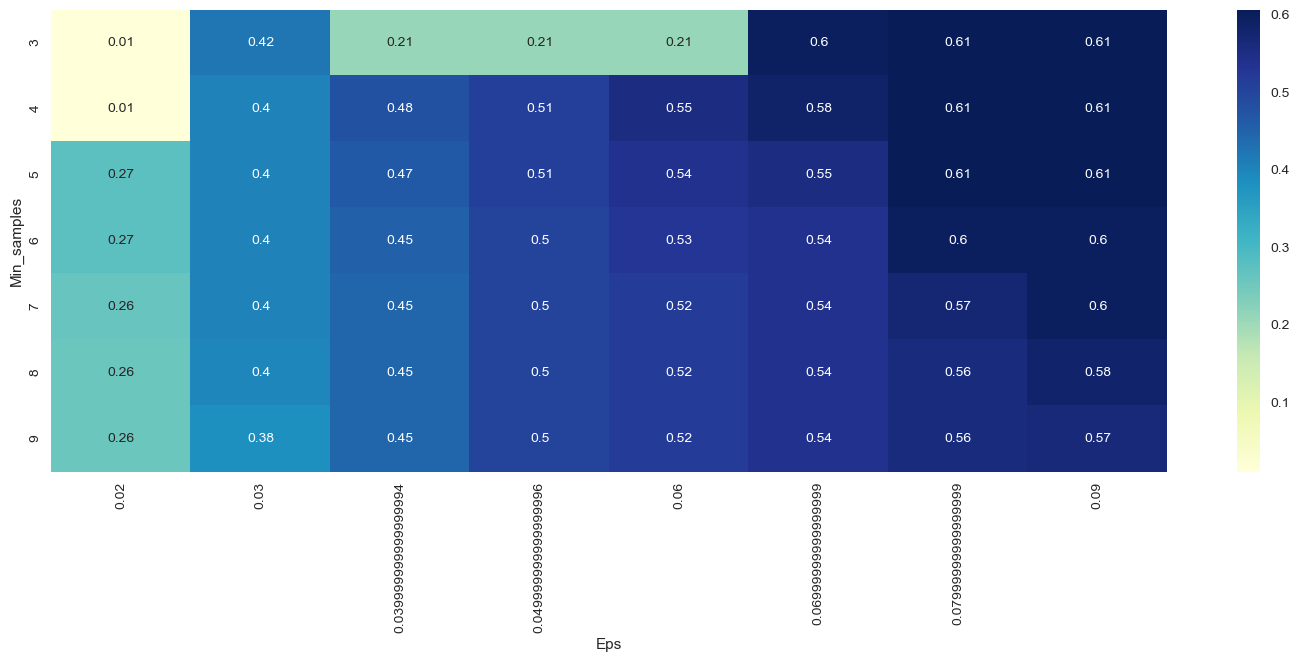

In [53]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [54]:
DBS_clustering = DBSCAN(eps=0.09, min_samples=3).fit(rfm_scaled)
clusters = DBS_clustering.labels_
DBSCAN_clustered = rfm
DBSCAN_clustered['Cluster'] = clusters + 1 
DBSCAN_clustered

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,325,1,77183.60,0
12347,1,6,3598.21,1
12348,74,3,904.44,1
12349,18,1,1757.55,1
12350,309,1,334.40,1
...,...,...,...,...
18280,277,1,180.60,1
18281,180,1,80.82,1
18282,7,2,178.05,1


In [55]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
0,17
1,4202


DBSCAN đã tạo một cụm (1) và một cụm ngoại lệ (0). Có 17 ngoại lệ